In [197]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import time
import itertools
environmental_data = pd.read_csv('environmental_data.csv')

## Preparing Data for Modelling

In [198]:
#Selecting the Environmental Dimension aspect based on EDA findings
data_subset = environmental_data[environmental_data.aspectname=='Environmental Dimension']

In [199]:
#normalising score value to a 0-1 scale
environmentcopy = data_subset.copy()
environmentcopy['scorevalue'] = (environmentcopy['scorevalue'] - environmentcopy['scorevalue'].min()) / (environmentcopy['scorevalue'].max() - environmentcopy['scorevalue'].min())    

In [200]:
#Defining score values above the median score as good(1) and score values below the median score as bad(0)
environmentcopy.loc[:,'scorevalue'] = environmentcopy.loc[:,'scorevalue'].apply(lambda x: 1 if x>environmentcopy.scorevalue.median() else 0)

In [201]:
#Randomly selecting 80% of observations as training data as 20% of the observations as testing data
training_data = environmentcopy.sample(frac=0.8, random_state=20)
testing_data = environmentcopy.drop(training_data.index)

## Base Model

In [202]:
#Creating a base model with all the available variables as predictors (no selection and no transformations)
logit_model_base = sm.logit(formula = 'scorevalue~mktcap_annual+curr_ratio+debt_assets+roe+gpm+csasectorname+at_turn+bm', data = training_data).fit() 
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.609047
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             scorevalue   No. Observations:                11773
Model:                          Logit   Df Residuals:                    11746
Method:                           MLE   Df Model:                           26
Date:                Wed, 01 Mar 2023   Pseudo R-squ.:                  0.1518
Time:                        16:07:26   Log-Likelihood:                -6913.1
converged:                       True   LL-Null:                       -8150.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  -9.6427      1.004     -9.607      0.000     -11.610      -7.675
csasectorname[T.Consumer Discretionary]     1.0706      0.125      8.588      0.000       0.826       1.315
csasectorname[T.Consumer Staples]           1.2814      0.139      9.202      0.000       1.008       1.554
csasectorname[T.Energy]                     1.2789      0.141      9.063      0.000       1.002       1.555
csasectorname[T.Financials]                 1.0857      0.194      5.609      0.000       0.706       1.465
csasectorname[T.Health Care]                0.6537      0.126      5.169      0.000       0.406       0.902
csasectorname[T.Industrials]                1.4517      0.124     11.738      0.000       1.209       1.694
csasectorname[T.Information Technology]     1.0799      0.123      8.792      0.000       0.839       1.321
csasectorname[T.Materials]                  1.9563      0.138     14.168      0.000       1.686       2.227
csasectorname[T.Real Estate]                0.4983      0.398      1.251      0.211      -0.283       1.279
csasectorname[T.Utilities]                  1.4832      0.146     10.129      0.000       1.196       1.770
log_mktcap_annual                           0.3572      0.045      8.013      0.000       0.270       0.445
debt_assets                                -8.0657      1.741     -4.633      0.000     -11.478      -4.653
log_mktcap_annual_log_curr_ratio           -0.0055      0.004     -1.269      0.204      -0.014       0.003
log_mktcap_annual_debt_assets               0.3537      0.075      4.720      0.000       0.207       0.501
log_curr_ratio_roe                          0.1100      0.033      3.349      0.001       0.046       0.174
log_curr_ratio_debt_assets                  0.0593      0.158      0.376      0.707      -0.249       0.368
roe_debt_assets                            -0.1133      0.030     -3.820      0.000      -0.171      -0.055
debt_assets1                                0.3656      0.123      2.973      0.003       0.125       0.607
debt_assets2                                0.4666      0.161      2.906      0.004       0.152       0.781
debt_assets3                                0.5786      0.190      3.039      0.002       0.205       0.952
debt_assets4                                0.7014      0.218      3.223      0.001       0.275       1.128
debt_assets5                                0.5920      0.246      2.405      0.016       0.109       1.074
debt_assets6                                0.6923      0.274      2.525      0.012       0.155       1.230
debt_assets7                                0.8214      0.311      2.642      0.008       0.212       1.431
debt_assets8                                1.0873      0.361      3.010      0.003       0.379       1.795
debt_assets9                                0.6764      0.408      1.657      0.098      -0.124       1.476
=

In [203]:
def confusion_matrix_train(model,cutoff=0.49):
    cm_df = pd.DataFrame(model.pred_table(threshold = cutoff))
    cm_df.columns = ['Predicted 0', 'Predicted 1'] 
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    cm = np.array(cm_df)
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    print("Classification accuracy = {:.1%}".format(accuracy))

Classification accuracy = 65.9%


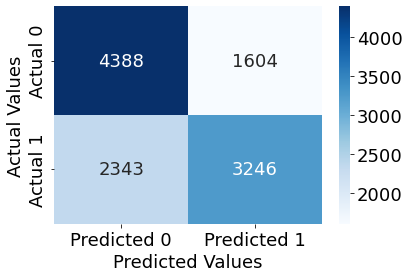

In [204]:
confusion_matrix_train(logit_model_base)

In [205]:
def confusion_matrix_test(data,actual_values,model,cutoff=0.49):
    pred_values = model.predict(data)
    bins=np.array([0,cutoff,1])
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))

Classification accuracy = 65.0%


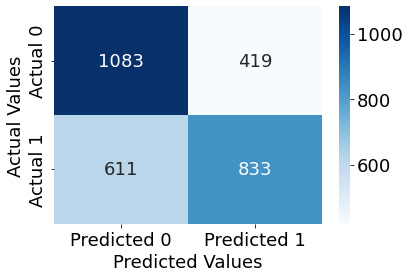

In [206]:
confusion_matrix_test(testing_data,testing_data.scorevalue,logit_model_base)

The base model has an accuracy of approximately 65%

## Variable Transformation

In [207]:
#Transforming maktcap_annual to log of mktcap_annual based on EDA findings
training_data['log_mktcap_annual']=np.log(training_data.mktcap_annual)
testing_data['log_mktcap_annual']=np.log(testing_data.mktcap_annual)

In [208]:
#Transforming curr_ratio to log of curr_ratio based on EDA findings
training_data['log_curr_ratio']=np.log(training_data.curr_ratio)
testing_data['log_curr_ratio']=np.log(testing_data.curr_ratio)

In [209]:
#Creating a function to bin debt_assets so that it can be applied to both the test and train datasets
def var_transform(data):
    binned_debt_assets = pd.qcut(environmentcopy['debt_assets'],10,retbins=True)
    bins = binned_debt_assets[1]
    data['binned_debt_assets'] = pd.cut(data['debt_assets'],bins = bins)
    dum = pd.get_dummies(data.binned_debt_assets,drop_first = True)
    dum.columns = ['debt_assets'+str(x) for x in range(1,len(bins)-1)]
    data = pd.concat([data,dum], axis = 1)
    return data

training_data = var_transform(training_data)
testing_data = var_transform(testing_data)

## Best Subset Selection

In [210]:
X = training_data[['log_mktcap_annual','log_curr_ratio','roe','debt_assets']]
X_backup = training_data[['log_mktcap_annual','log_curr_ratio','roe','debt_assets']]

In [211]:
for combo in itertools.combinations(X_backup.columns, 2):    
    training_data['_'.join(combo)] = training_data[combo[0]]*training_data[combo[1]]
    testing_data['_'.join(combo)] = testing_data[combo[0]]*testing_data[combo[1]]
    X.loc[:,'_'.join(combo)] = training_data.loc[:,'_'.join(combo)] 

/var/folders/3h/k0g6ghyn3zndkmqj3swzqhxr0000gn/T/ipykernel_57570/3336649328.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'_'.join(combo)] = training_data.loc[:,'_'.join(combo)]
/var/folders/3h/k0g6ghyn3zndkmqj3swzqhxr0000gn/T/ipykernel_57570/3336649328.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'_'.join(combo)] = training_data.loc[:,'_'.join(combo)]
/var/folders/3h/k0g6ghyn3zndkmqj3swzqhxr0000gn/T/ipykernel_57570/3336649328.py:4: SettingWithCopyWarning: 
A value is trying to 

In [212]:
def processSubset(predictor_subset):
    model = sm.ols('scorevalue~' + '+'.join(predictor_subset),data = training_data).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}

In [213]:
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [214]:
models_best = pd.DataFrame(columns=["Rsquared", "model"])

tic = time.time()
for i in range(1,1+X.shape[1]):
    models_best.loc[i] = getBest_model(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 10 models on 1 predictors in 0.07670235633850098 seconds.
Processed 45 models on 2 predictors in 0.33516526222229004 seconds.
Processed 120 models on 3 predictors in 1.170790195465088 seconds.
Processed 210 models on 4 predictors in 2.060405969619751 seconds.
Processed 252 models on 5 predictors in 2.824157238006592 seconds.
Processed 210 models on 6 predictors in 2.7501440048217773 seconds.
Processed 120 models on 7 predictors in 1.786391019821167 seconds.
Processed 45 models on 8 predictors in 0.7051839828491211 seconds.
Processed 10 models on 9 predictors in 0.17017912864685059 seconds.
Processed 1 models on 10 predictors in 0.020663976669311523 seconds.
Total elapsed time: 12.098020076751709 seconds.


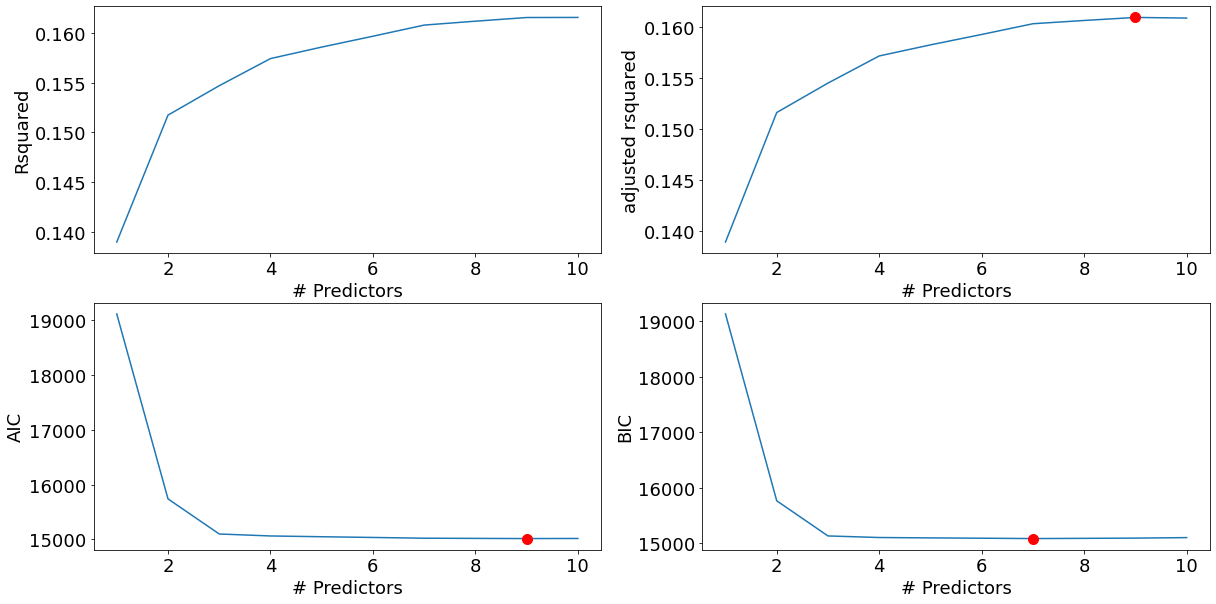

In [215]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

In [216]:
best_interaction_model = models_best['model'][7]
best_interaction_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             scorevalue   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     322.0
Date:                Wed, 01 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:07:49   Log-Likelihood:                -7503.2
No. Observations:               11773   AIC:                         1.502e+04
Df Residuals:                   11765   BIC:                         1.508e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.1681      0.175     -6.658      0.000      -1.512      -0.824
log_mktcap_annual                    0.0718      0.008      9.188      0.000       0.057       0.087
debt_assets                         -1.4370      0.293     -4.912      0.000      -2.010      -0.864
log_mktcap_annual_log_curr_ratio    -0.0043      0.001     -6.378      0.000      -0.006      -0.003
log_mktcap_annual_debt_assets        0.0698      0.013      5.379      0.000       0.044       0.095
log_curr_ratio_roe                   0.0243      0.005      4.691      0.000       0.014       0.035
log_curr_ratio_debt_assets           0.1009      0.025      4.019      0.000       0.052       0.150
roe_debt_assets                     -0.0256      0.005     -5.141      0.000      -0.035      -0.016
==============================================================================
Omnibus:                   109865.925   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              981.418
Skew:                           0.094   Prob(JB):                    7.72e-214
Kurtosis:                       1.598   Cond. No.                     2.40e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Building the Model

In [217]:
#Building the model using the transformed predictors as well as the best subset of predictors found during best subset selection
logit_model = sm.logit(formula = 'scorevalue~log_mktcap_annual+debt_assets+log_mktcap_annual_log_curr_ratio+log_mktcap_annual_debt_assets+log_curr_ratio_roe+log_curr_ratio_debt_assets+roe_debt_assets+csasectorname+debt_assets1+debt_assets2+debt_assets3+debt_assets4+debt_assets5+debt_assets6+debt_assets7+debt_assets8+debt_assets9', data = training_data).fit() 
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.587200
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             scorevalue   No. Observations:                11773
Model:                          Logit   Df Residuals:                    11746
Method:                           MLE   Df Model:                           26
Date:                Wed, 01 Mar 2023   Pseudo R-squ.:                  0.1518
Time:                        16:07:49   Log-Likelihood:                -6913.1
converged:                       True   LL-Null:                       -8150.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  -9.6427      1.004     -9.607      0.000     -11.610      -7.675
csasectorname[T.Consumer Discretionary]     1.0706      0.125      8.588      0.000       0.826       1.315
csasectorname[T.Consumer Staples]           1.2814      0.139      9.202      0.000       1.008       1.554
csasectorname[T.Energy]                     1.2789      0.141      9.063      0.000       1.002       1.555
csasectorname[T.Financials]                 1.0857      0.194      5.609      0.000       0.706       1.465
csasectorname[T.Health Care]                0.6537      0.126      5.169      0.000       0.406       0.902
csasectorname[T.Industrials]                1.4517      0.124     11.738      0.000       1.209       1.694
csasectorname[T.Information Technology]     1.0799      0.123      8.792      0.000       0.839       1.321
csasectorname[T.Materials]                  1.9563      0.138     14.168      0.000       1.686       2.227
csasectorname[T.Real Estate]                0.4983      0.398      1.251      0.211      -0.283       1.279
csasectorname[T.Utilities]                  1.4832      0.146     10.129      0.000       1.196       1.770
log_mktcap_annual                           0.3572      0.045      8.013      0.000       0.270       0.445
debt_assets                                -8.0657      1.741     -4.633      0.000     -11.478      -4.653
log_mktcap_annual_log_curr_ratio           -0.0055      0.004     -1.269      0.204      -0.014       0.003
log_mktcap_annual_debt_assets               0.3537      0.075      4.720      0.000       0.207       0.501
log_curr_ratio_roe                          0.1100      0.033      3.349      0.001       0.046       0.174
log_curr_ratio_debt_assets                  0.0593      0.158      0.376      0.707      -0.249       0.368
roe_debt_assets                            -0.1133      0.030     -3.820      0.000      -0.171      -0.055
debt_assets1                                0.3656      0.123      2.973      0.003       0.125       0.607
debt_assets2                                0.4666      0.161      2.906      0.004       0.152       0.781
debt_assets3                                0.5786      0.190      3.039      0.002       0.205       0.952
debt_assets4                                0.7014      0.218      3.223      0.001       0.275       1.128
debt_assets5                                0.5920      0.246      2.405      0.016       0.109       1.074
debt_assets6                                0.6923      0.274      2.525      0.012       0.155       1.230
debt_assets7                                0.8214      0.311      2.642      0.008       0.212       1.431
debt_assets8                                1.0873      0.361      3.010      0.003       0.379       1.795
debt_assets9                                0.6764      0.408      1.657      0.098      -0.124       1.476
=

Classification accuracy = 68.2%


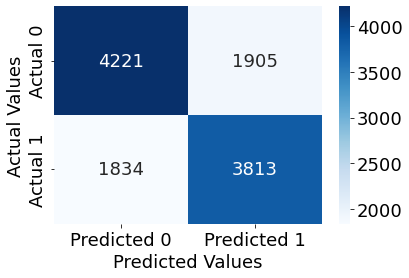

In [218]:
confusion_matrix_train(logit_model)

Classification accuracy = 69.2%


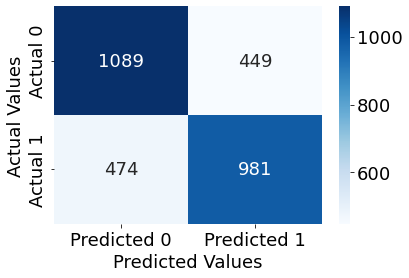

In [219]:
confusion_matrix_test(testing_data,testing_data.scorevalue,logit_model)

## ROC Curve

In [220]:
training_data.dropna(subset=['log_mktcap_annual','debt_assets','log_mktcap_annual_log_curr_ratio','log_mktcap_annual_debt_assets','log_curr_ratio_roe','log_curr_ratio_debt_assets','roe_debt_assets','csasectorname'],inplace=True)            

0.7519850248263245


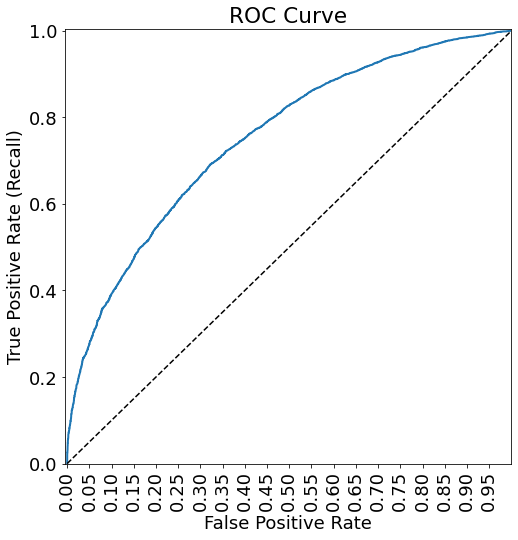

In [221]:
from sklearn.metrics import roc_curve, auc
y=training_data.scorevalue
ypred = logit_model.predict(training_data)
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
plot_roc_curve(fpr, tpr)

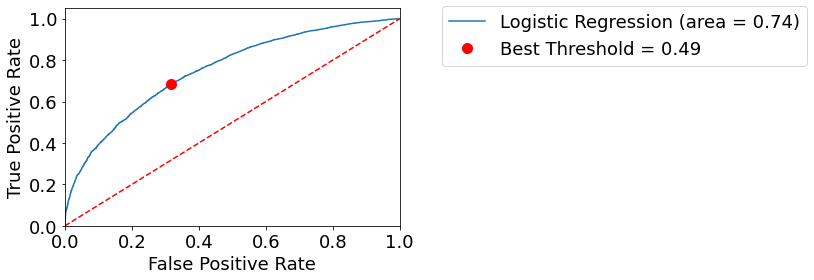

In [222]:
#Finding the Best Threshold to maximize Accuracy
logit_roc_auc = 0.7430920109830258
o_tpr = tpr[np.argmin(np.abs(fpr+tpr-1))]
o_fpr = fpr[np.argmin(np.abs(fpr+tpr-1))]
o_threshold = auc_thresholds[np.argmin(np.abs(fpr+tpr-1))]
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.plot(o_fpr, o_tpr, 'ro', label='Best Threshold = %0.2f' % o_threshold)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

## Precision-Recall Curve

In [223]:
from sklearn.metrics import precision_recall_curve
y=training_data.scorevalue
ypred = logit_model.predict(training_data)
p, r, thresholds = precision_recall_curve(y, ypred)

In [224]:
#Finding precision and recall values for optimized threshold value
optimal_idx = np.where(thresholds==auc_thresholds[np.argmin(np.abs(fpr+tpr-1))])

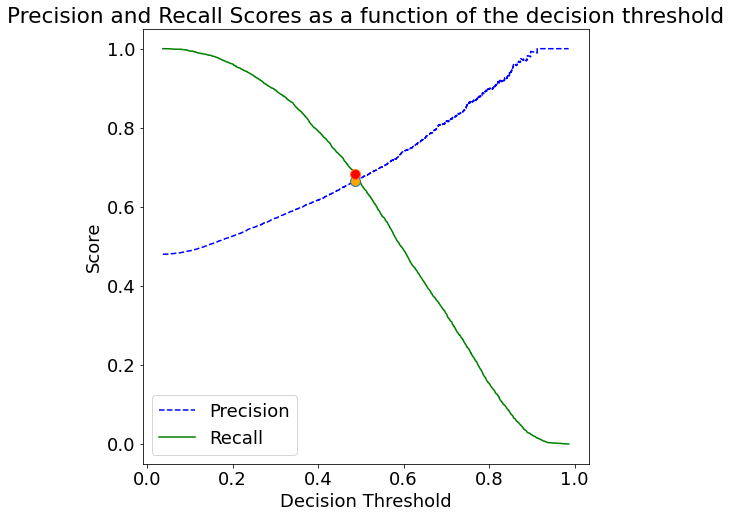

In [225]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)
plt.plot(thresholds[optimal_idx],p[optimal_idx],marker="o", markersize=10, markerfacecolor="orange")
plt.plot(thresholds[optimal_idx],r[optimal_idx],marker="o", markersize=10, markerfacecolor="red")